## LFPy passive e-model with synaptic input: Plot LFP Heatmap
Adapted from LFPy Github  https://github.com/LFPy/LFPy/blob/master/examples/LFPy-example-02.ipynb

Modified by: Darshan Mandge, Open Brain Institute

Copyright (c) 2025 Open Brain Institute


The following notebook show the extracellular response of a synaptic input to a passive cADpyr neuron. To use it for a different model replace the morphology in the CellParameters dictionary.

## Get the data
We can get the data using the entitysdk package. It has a function dedicated to download a SimulatableNeuron (also called MEModel). It will download a hoc file, a morphology and mechanisms (ion channel models).

To download the files, execute the following cell, and click on the link to set up authentication with the platform. If the code does not work, you might have to update the memodel_id, since it can change after a new deployment of the database.

In [1]:
from obi_auth import get_token
from entitysdk.client import Client
from entitysdk.downloaders.memodel import download_memodel
from entitysdk.models import MEModel


memodel_id = "9d4f3e32-1672-4265-bd6a-79067b52cab6"

token = get_token(environment="staging", auth_mode="daf")
client = Client(environment="staging", token_manager=token)

memodel = client.get_entity(
    entity_type=MEModel,
    entity_id=memodel_id,
)
downloaded_memodel = download_memodel(
    client, memodel=memodel
)

hoc_file = downloaded_memodel.hoc_path
morph_file = downloaded_memodel.morphology_path
mechanisms_folder = downloaded_memodel.mechanisms_dir

Next you will have to compile the mechanisms.

In [3]:
!nrnivmodl mechanisms

# Alternatively 
# import os
# os.system(f"{venv_path}/bin/nrnivmodl mechanisms")

/Users/aurelien/venvs/venv-py312/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/aurelien/repos/obi_platform_analysis_notebooks/Cellular/emodels/lfpy_simulations/passive_emodel_synapses_heatmap
Mod files: "mechanisms/mechanisms/CaDynamics_DC0.mod" "mechanisms/mechanisms/Ca_HVA2.mod" "mechanisms/mechanisms/Ca_LVAst.mod" "mechanisms/mechanisms/Ih.mod" "mechanisms/mechanisms/K_Pst.mod" "mechanisms/mechanisms/K_Tst.mod" "mechanisms/mechanisms/NaTg.mod" "mechanisms/mechanisms/Nap_Et2.mod" "mechanisms/mechanisms/SK_E2.mod" "mechanisms/mechanisms/SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import LFPy

--No graphics will be displayed.


Create some dictionarys with parameters for cell, synapse and extracellular electrode:

In [5]:
# Parameters for the cell model
cellParameters = {
    'morphology':str(morph_file), # e-model moprhology
    'tstart': -50, # start time of simulation, recorders start at t=0
    'tstop': 100, # end time of simulation
    'dt': 2**-4, # time resolution of simulation
    'passive': True, # switch on passive mechanims. Remove ionic mechanisms.
}

# Parameters for the synapse
synapseParameters = {
    'syntype': 'Exp2Syn', # NEURON/LFPy biexponential synapse model
    # https://nrn.readthedocs.io/en/latest/python/modelspec/programmatic/mechanisms/mech.html#Exp2Syn
    'e': 0.,     # reversal potential
    'tau1': 0.5, # first time constant
    'tau2': 2.0, # second time constant
    'weight': 0.005, # synaptic weight
    'record_current': True, # record synapse current
}

# Parameters for the electrode
z = np.mgrid[-400:1201:100] # z positions of the electrodes

electrodeParameters = {
    'x': np.zeros(z.size),
    'y': np.zeros(z.size),
    'z': z,
    'sigma': 0.3, # extracellular conductivity
}

Then, create the **`cell`**, **`synapse`** and **`electrode`** objects using the
**`LFPy.Cell`**, **`LFPy.Synapse`**, **`LFPy.RecExtElectrode`** classes.

In [6]:
# Define cell
cell = LFPy.Cell(**cellParameters)

# Set cell position close to the electrode
cell.set_pos(x=-10, y=0, z=0)


# Set cell rotation
# These values set (with trial-and-error) to get good amplitude of LFP
cell.set_rotation(x=4.98919, y=9.3, z=0)
# cell.set_rotation(x=4.98919, y=-4.33261, z=np.pi)

# Define synapse at a section closest to z = 800 um
# https://github.com/LFPy/LFPy/blob/ab7809fa75f33e9012f05b1fefb168e3bd126ba3/LFPy/pointprocess.py#L61
synapse = LFPy.Synapse(cell,
                       idx = cell.get_closest_idx(z=800),
                       **synapseParameters)
synapse.set_spike_times(np.array([10, 30, 50]))

# Define extracellular potential electrode
# https://github.com/LFPy/LFPy/blob/ab7809fa75f33e9012f05b1fefb168e3bd126ba3/LFPy/recextelectrode.py#L23C7-L23C22
electrode = LFPy.RecExtElectrode(cell, **electrodeParameters)

Run the simulation using **`cell.simulate()`** probing the extracellular potential with 
the additional keyword argument **`probes=[electrode]`**

In [7]:
# Simulate cell and record for electrode LFPy.RecExtElectrode
# https://github.com/LFPy/LFPy/blob/ab7809fa75f33e9012f05b1fefb168e3bd126ba3/LFPy/cell.py#L936

cell.simulate(probes=[electrode])

Then plot the **somatic potential** and the **prediction** obtained using the `RecExtElectrode` instance 
(now accessible as `electrode.data`):

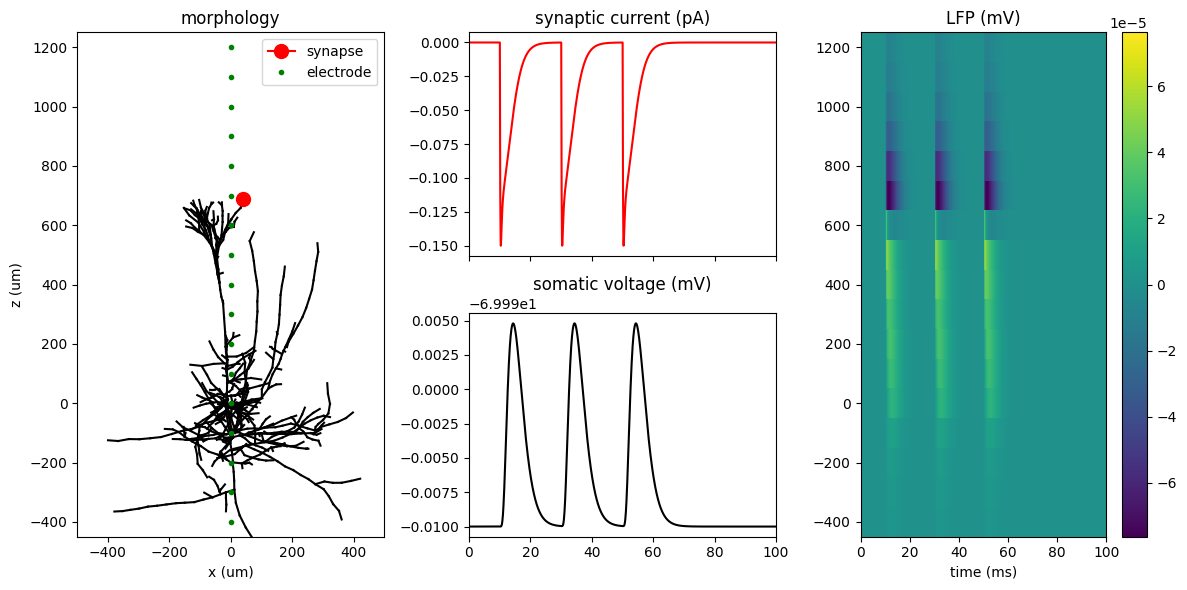

In [8]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3)

ax0 = fig.add_subplot(gs[:, 0])
ax0.plot(cell.x.T, cell.z.T, 'k')
ax0.plot(synapse.x, synapse.z, 
         color='r', marker='o', markersize=10,
         label='synapse')
ax0.plot(electrode.x, electrode.z, '.', color='g', 
         label='electrode')
ax0.axis([-500, 500, -450, 1250])
ax0.legend()
ax0.set_xlabel('x (um)')
ax0.set_ylabel('z (um)')
ax0.set_title('morphology')

ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(cell.tvec, synapse.i, 'r')
ax1.set_title('synaptic current (pA)')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
ax2.plot(cell.tvec, cell.somav, 'k')
ax2.set_title('somatic voltage (mV)')

ax3 = fig.add_subplot(gs[:, 2], sharey=ax0, sharex=ax1)
im = ax3.pcolormesh(cell.tvec, electrode.z, electrode.data,
                 vmin=-abs(electrode.data).max(), vmax=abs(electrode.data).max(),
                 shading='auto')
plt.colorbar(im)
ax3.set_title('LFP (mV)')
ax3.set_xlabel('time (ms)')
plt.tight_layout()

#fig.savefig('LFPy-example-02.pdf', dpi=300)